In [ ]:
# default_exp layers

# Layers

> Custom activations, layers, and layer blocks are contained in this module.

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# export
from functools import partial
import numpy as np
from operator import add, truediv, sub
import torch
import torch.nn as nn
import torch.nn.functional as F

from htools import add_docstring
from incendio.data import probabilistic_hash_tensor
from incendio.utils import concat, weighted_avg, identity

In [ ]:
# Used for testing only.
from collections import defaultdict, Counter
from itertools import chain
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import Dataset, DataLoader

from htools import assert_raises, InvalidArgumentError
from incendio.data import probabilistic_hash_item
import pandas_htools

## Activations

In [ ]:
# export
class GRelu(nn.Module):
    """Generic ReLU."""

    def __init__(self, leak=0.0, max=float('inf'), sub=0.0):
        super().__init__()
        self.leak = leak
        self.max = max
        self.sub = sub

    def forward(self, x):
        """Check which operations are necessary to save computation."""
        x = F.leaky_relu(x, self.leak) if self.leak else F.relu(x)
        if self.sub:
            x -= self.sub
        if self.max:
            x = torch.clamp(x, max=self.max)
        return x

    def __repr__(self):
        return f'GReLU(leak={self.leak}, max={self.max}, sub={self.sub})'

In [ ]:
# export
JRelu = GRelu(leak=.1, sub=.4, max=6.0)

In [ ]:
# export
class Mish(nn.Module):
    """OOP form of mish activation.

    Mish: A Self Regularized Non-Monotonic Neural Activation Function
    https://arxiv.org/pdf/1908.08681v1.pdf
    """

    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x * torch.tanh(F.softplus(x))

In [ ]:
# export
def mish(x):
    """Functional form of mish activation.

    Mish: A Self Regularized Non-Monotonic Neural Activation Function
    https://arxiv.org/pdf/1908.08681v1.pdf

    Parameters
    ----------
    x: torch.Tensor[float]
        Input tensor.
    Returns
    -------
    torch.Tensor[float]: Tensor of same shape as input x.
    """
    return x * torch.tanh(F.softplus(x))

In [ ]:
def plot_activations(z, a, mode='scatter', **kwargs):
    """Plot an input tensor and its corresponding activations.  Both tensors
    will be flattened for plotting.
    
    Parameters
    ----------
    z: tf.Tensor
        Tensor containing values to plot on the x axis (we can often think of
        this as the output of a linear layer, where z=f(x) and a=mish(z)).
    a: tf.Tensor
        Tensor containing values to plot on y axis.
    mode: str
        'scatter' for scatter plot or 'plot' for line plot.
    kwargs: Values to be passed to the matplotlib plotting function, such as 
        's' when in 'scatter' mode or 'lw' in 'plot' mode.
        
    Returns
    -------
    None
    """
    plt_func = getattr(plt, mode)
    kwargs = kwargs or {}
    if mode == 'scatter' and not kwargs:
        kwargs = {'s': .75}
    plt_func(z.numpy().flatten(), a.numpy().flatten(), **kwargs)
    plt.axvline(0, lw=.5, alpha=.5)
    plt.axhline(0, lw=.5, alpha=.5)
    plt.show()

In [ ]:
x = torch.arange(-5, 5, .05)
a = mish(x)

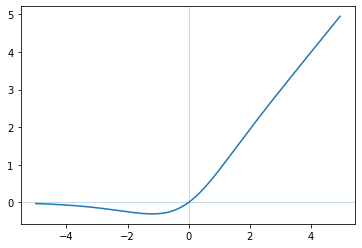

In [ ]:
plot_activations(x, a, 'plot')

## Layer Blocks

In [ ]:
# export
class ConvBlock(nn.Module):
    """Create a convolutional block optionally followed by a batch norm layer.
    """

    def __init__(self, c_in, c_out, kernel_size=3, norm=True, activation=JRelu,
                 **kwargs):
        """
        Parameters
        -----------
        c_in: int
            # of input channels.
        c_out: int
            # of output channels.
        kernel_size: int
            Size of kernel in conv2d layer. An integer argument will be used
            as both the height and width.
        norm: bool
            If True, include a batch norm layer after the conv layer. If False,
            no norm layer will be used. Note that batch norm has learnable
            affine parameters which remove the need for a bias in the preceding
            conv layer. When batch norm is not used, however, the conv layer
            will include a bias term.
        activation: nn.Module
            Activation function to use at the end of the convolutional block.
            (In some cases such as our ResBlock implementation, we pass in None
            so that an extra addition can be performed before the final
            activation.) Do not use the functional form here as it will be
            added to a sequential object.
        kwargs: any
            Additional keyword args are passed to Conv2d. Useful kwargs include
            stride, and padding (see pytorch docs for nn.Conv2d).
        """
        super().__init__()
        self.norm = norm
        layers = [nn.Conv2d(c_in, c_out, kernel_size, bias=not norm, **kwargs)]
        if norm:
            layers.append(nn.BatchNorm2d(c_out))
        if activation is not None:
            layers.append(activation)
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)

In [ ]:
conv = ConvBlock(3, 5, norm=False)
conv

ConvBlock(
  (block): Sequential(
    (0): Conv2d(3, 5, kernel_size=(3, 3), stride=(1, 1))
    (1): GReLU(leak=0.1, max=6.0, sub=0.4)
  )
)

In [ ]:
x = torch.rand(2, 3, 4, 4)
conv(x).shape

torch.Size([2, 5, 2, 2])

In [ ]:
# export
class ResBlock(nn.Module):

    def __init__(self, c_in, activation=JRelu, f=3, stride=1, pad=1,
                 skip_size=2, norm=True):
        """Residual block using 2D convolutional layers. Note that f,
        stride, and pad must be selected such that the height and width of 
        the input remain the same.

        Parameters
        -----------
        c_in: int
            # of input channels.
        activation: callable
            Activation function to use.
        f: int
            Size of filter (f x f) used in convolution. Default 3.
        stride: int
            # of pixels the filter moves between each convolution. Default 1.
        pad: int
            Pixel padding around the input. Default 1.
        skip_size: int
            Number of conv blocks inside the skip connection (default 2).
            ResNet paper notes that skipping a single layer did not show
            noticeable improvements.
        norm: bool
            Specifies whether to include a batch norm layer after each conv
            layer.
        """
        super().__init__()
        self.skip_size = skip_size
        self.layers = nn.ModuleList([
            ConvBlock(c_in, c_in, norm=norm, activation=None, kernel_size=f,
                      stride=stride, padding=pad)
            for i in range(skip_size)
        ])
        self.activation = activation

    def forward(self, x):
        x_out = x
        for i, layer in enumerate(self.layers):
            x_out = layer(x_out)

            # Final activation must be applied after addition.
            if i != self.skip_size - 1:
                x_out = self.activation(x_out)

        return self.activation(x + x_out)

In [ ]:
ResBlock(4)

ResBlock(
  (layers): ModuleList(
    (0): ConvBlock(
      (block): Sequential(
        (0): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): ConvBlock(
      (block): Sequential(
        (0): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
  )
  (activation): GReLU(leak=0.1, max=6.0, sub=0.4)
)

In [ ]:
ResBlock(4, norm=False)

ResBlock(
  (layers): ModuleList(
    (0): ConvBlock(
      (block): Sequential(
        (0): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (1): ConvBlock(
      (block): Sequential(
        (0): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
  )
  (activation): GReLU(leak=0.1, max=6.0, sub=0.4)
)

In [ ]:
# export
@add_docstring(nn.Conv2d)
class ReflectionPaddedConv2d(nn.Module):
    """Conv2d only allows padding_mode of `zeros` or `circular`. This
    layer is a quick way for us to use reflection padding.
    """
    
    def __init__(self, in_channels, out_channels, padding=1, 
                 kernel_size=3, **kwargs):
        """Do not specify a padding mode.
        """
        super().__init__()
        if 'padding_mode' in kwargs: 
            raise InvalidArgumentError('Remove `padding_mode` from arguments.')
        self.reflect = nn.ReflectionPad2d(padding)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size,
                              padding=0)
    
    def forward(self, x):
        x = self.reflect(x)
        return self.conv(x)

In [ ]:
def show_img(img):
    plt.imshow(img.permute(1, 2, 0) / 255)
    plt.show()

In [ ]:
rconv = ReflectionPaddedConv2d(3, 3, kernel_size=1, padding=2)
rconv

ReflectionPaddedConv2d(
  (reflect): ReflectionPad2d((2, 2, 2, 2))
  (conv): Conv2d(3, 3, kernel_size=(1, 1), stride=(1, 1))
)

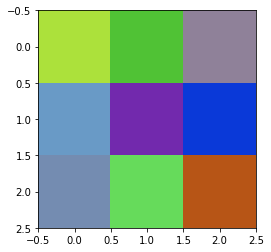

In [ ]:
x = torch.randint(255, (1, 3, 3, 3)).float()
show_img(x[0])

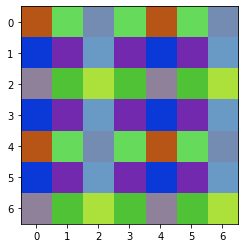

In [ ]:
x2 = rconv.reflect(x)
show_img(x2[0])

In [ ]:
# Tests
assert nn.Conv2d.__doc__ in ReflectionPaddedConv2d.__doc__

with assert_raises(InvalidArgumentError):
    ReflectionPaddedConv2d(3, 3, padding_mode='zeros')

As expected, got InvalidArgumentError(Remove `padding_mode` from arguments.).


In [ ]:
# export
class Dropin(nn.Module):
    """Additive dropout. This injects small amounts of noise into a model
    in the form of randomly generated floats from a zero-centered
    gaussian distribution (variance can be adjusted). This does nothing 
    in eval mode. Unlike Dropout, this does not scale weights during 
    training since it does not bias them in any direction.
    """
    
    def __init__(self, scale=.5):
        """
        Parameters
        ----------
        scale: float
            Used to scale the magnitude of the random noise. Keep in mind 
            that the scalar term is square rooted, so the relationship
            will not be linear. Relatively large values (e.g. 1.0) will have
            a stronger regularizing effect, while small values (e.g. 0.1)
            will have a slight regularizing effect. There is no max value
            enforced, so it's up to the user to select a reasonable value.
        """
        super().__init__()
        self.scale = scale
        
    def forward(self, x):
        if not self.training:
            return x
        
        # Storing noise allows us to run diagnostics.
        self.noise = torch.randn_like(x) * np.sqrt(self.scale / x.shape[-1])
        return x + self.noise

In [ ]:
class Net(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.drop = Dropin()
        
    def forward(self, x):
        return self.drop(x)

In [ ]:
net = Net()
x = torch.randn(8, 128, 128, 3)
assert np.corrcoef(net(x).flatten(), x.flatten())[0][1] > .9

In [ ]:
net.eval()
assert torch.eq(net(x), x).all()
assert not net.drop.training

In [ ]:
def simulate_activation_stats(scale=1.0, trials=10_000):
    act_stats = defaultdict(list)
    noise_stats = defaultdict(list)
    
    drop = Dropin(scale)
    for _ in range(trials):
        x = torch.randn(3, 4, dtype=torch.float)
        z = drop(x)
        noise = drop.noise
        noise_stats['mean'].append(noise.mean())
        noise_stats['std'].append(noise.std())
        noise_stats['act_corr'].append(
            np.corrcoef(z.flatten(), noise.flatten())[0][1]
        )
        
        act_stats['mean'].append(z.mean())
        act_stats['std'].append(z.std())
        act_stats['x_corr'].append(
            np.corrcoef(z.flatten(), x.flatten())[0][1]
        )

    return pd.DataFrame(dict(
        act={k: np.mean(v).round(4) for k, v in act_stats.items()}, 
        noise={k: np.mean(v).round(4) for k, v in noise_stats.items()}
    ))

In [ ]:
for scale in [10, 1, .75, .5, .25, .1]:
    print('\n', scale)
    simulate_activation_stats(scale, 1_000).pprint()


 10


,act,noise
mean,0.0132,0.0094
std,1.8189,1.5192
x_corr,0.5324,NaN
act_corr,NaN,0.8304



 1


,act,noise
mean,-0.0141,0.0034
std,1.0921,0.4870
x_corr,0.8855,NaN
act_corr,NaN,0.4282



 0.75


,act,noise
mean,-0.0015,0.0022
std,1.0633,0.4240
x_corr,0.9100,NaN
act_corr,NaN,0.3899



 0.5


,act,noise
mean,0.0107,0.0008
std,1.0558,0.3442
x_corr,0.9409,NaN
act_corr,NaN,0.3235



 0.25


,act,noise
mean,0.0098,-0.0057
std,1.0013,0.2461
x_corr,0.9667,NaN
act_corr,NaN,0.2298



 0.1


,act,noise
mean,-0.0057,-0.0014
std,0.9969,0.1533
x_corr,0.9868,NaN
act_corr,NaN,0.1394


In [ ]:
# export
class LinearSkipBlock(nn.Module):
    """This lets us easily create residual block equivalents with linear
    layers.
    """
    
    def __init__(self, x_dim, layer_dims, op, activation=mish):
        """
        Parameters
        ----------
        x_dim: int
            Size of input tensor.
        layer_dims: Iterable[int]
            Size of each layer. The length of this list will be the skip size
            (2 is probably a reasonable starting point).
        op: function
            This will be called on the input x and the processed x in the
            forward method. This is a concatenation for dense blocks and an
            addition for residual blocks, but any operation is possible.
        activation: callable
            Activation function or callable class. This will be applied after
            each layer. The final activation is applied after the `op` function.
        """
        super().__init__()
        self.skip_size = len(layer_dims)
        self.activation = activation
        self.layers = nn.ModuleList([nn.Linear(d_in, d_out) for d_in, d_out
                                     in zip([x_dim]+list(layer_dims), layer_dims)])
        self.op = op
            
    def forward(self, x):
        out = x
        for i, layer in enumerate(self.layers, 1):
            out = layer(out)
            if i < self.skip_size: out = self.activation(out)
        return self.activation(self.op(x, out))

In [ ]:
# export
class LinearResBlock(LinearSkipBlock):
    """Equivalent of ResNet block with linear layers."""
    
    def __init__(self, x_dim, hidden_dims, activation=mish):
        if hidden_dims[-1] != x_dim:
            raise InvalidArgumentError(
                'Last hidden dimension must match input dimension.'
            )
        super().__init__(x_dim, hidden_dims, add, activation)

In [ ]:
# export
class LinearDenseBlock(LinearSkipBlock):
    """Equivalent of DenseNet block with linear layers."""
    
    def __init__(self, x_dim, hidden_dims, activation=mish):
        super().__init__(x_dim, hidden_dims, concat, activation)

In [ ]:
# export
class WeightedLinearResBlock(LinearSkipBlock):
    """Like a LinearResBlock but takes a weighted average of the input and output
    rather than adding them. Addition gives them equal weight and we may want to 
    weight the output more heavily.
    """
    
    def __init__(self, x_dim, hidden_dims, weights=(.25, .75), activation=mish):
        super().__init__(x_dim, hidden_dims, 
                         partial(weighted_avg, weights=list(weights)), activation)

## Embeddings and Encodings

In [ ]:
# export
def trunc_normal_(x, mean=0.0, std=1.0):
    """Ported from fastai to remove dependency: 
    
    Truncated normal initialization.
    From https://discuss.pytorch.org/t/implementing-truncated-normal-initializer/4778/12
    """
    return x.normal_().fmod_(2).mul_(std).add_(mean)

In [ ]:
# export
@add_docstring(nn.Embedding)
def PaddedEmbedding(num_embeddings, embedding_dim, padding_idx=None, **kwargs):
    """Patched version of Fastai `embedding` that allows us to specify a row of
    zeros for a padding token.
    """
    emb = nn.Embedding(num_embeddings, embedding_dim, padding_idx, **kwargs)
    with torch.no_grad():
        trunc_normal_(emb.weight, std=.01)
        if padding_idx is not None:
            torch.zero_(emb.weight[0])
    return emb

In [ ]:
PaddedEmbedding(4, 3, 0).weight

Parameter containing:
tensor([[ 0.0000,  0.0000,  0.0000],
        [ 0.0145, -0.0067, -0.0038],
        [-0.0176, -0.0179,  0.0010],
        [-0.0042, -0.0020,  0.0027]], requires_grad=True)

In [ ]:
# export
class BloomEmbedding(nn.Module):
    """Bloom Embedding layer for memory-efficient word representations.
    Each word is encoded by a combination of rows of the embedding
    matrix. The number of rows can therefore be far lower than the number
    of words in our vocabulary while still providing unique representations.
    The reduction in rows allows us to use memory in other ways: a larger
    embedding dimension, more or larger layers after the embedding,
    larger batch sizes, etc.
    
    Note that if hashing is done in the Dataset, we could use a simple
    nn.EmbeddingBag to achieve the same thing. Many users have reported 
    poor performance with this layer though (especially on CPU, but in some
    cases on GPU) so I stick with the standard Embedding. We also bake in
    the truncated normal intialization provided by fastai, with a slight tweak
    to allow a row for padding.
    """
    
    def __init__(self, n_emb=251, emb_dim=100, n_hashes=4, padding_idx=0,
                 pre_hashed=False):
        """
        Parameters
        ----------
        n_emb: int
            Number of rows to create in the embedding matrix. A prime
            number is recommended. Lower numbers will be more 
            memory-efficient but increase the chances of collisions.
        emb_dim: int
            Size of each embedding. If emb_dim=100, each word will
            be represented by a 100-dimensional vector.
        n_hashes: int
            This determines the number of hashes that will be taken
            for each word index, and as a result, the number of rows
            that will be summed to create each unique representation.
            The higher the number, the lower the chances of a collision.
        padding_idx: int or None
            If an integer is provided, this will set aside the corresponding
            row in the embedding matrix as a vector of zeros. If None, no
            padding vector will be allocated.
        pre_hashed: bool
            Pass in True if the input tensor will already be hashed by the time 
            it enters this layer (you may prefer pre-compute the hashes in the
            Dataset to save computation time during training). In this
            scenario, the layer is a simple embedding bag with mode "sum". 
            Pass in False if the inputs will be word indices that have not yet
            been hashed. In this case, hashing will be done inside the 
            `forward` call.
            
        Suggested values for a vocab size of ~30,000:
        
        | n_emb | n_hashes | unique combos |
        |-------|----------|---------------|
        | 127   | 5        | 29,998        |
        | 251   | 4        | 29,996        |
        | 997   | 3        | 29,997        |
        | 5,003 | 2        | 29,969        |
        """
        super().__init__()
        self.n_emb = n_emb
        self.emb = PaddedEmbedding(n_emb, emb_dim, padding_idx=padding_idx)
        self.n_hashes = n_hashes
        self.pad_idx = padding_idx
        self.pre_hashed = pre_hashed
        self.process_fn = identity if pre_hashed else \
            partial(probabilistic_hash_tensor, n_buckets=n_emb,
                    n_hashes=n_hashes, pad_idx=pad_idx)
        
    def forward(self, x):
        """
        Parameters
        ----------
        x: torch.LongTensor
            Input tensor of word indices (bs x seq_len) if pre_hashed is False.
            Hashed indices (bs x seq_len x n_hashes) if pre_hashed is False.
            
        Returns
        -------
        torch.FloatTensor: Words encoded with combination of embeddings.
            (bs x seq_len x emb_dim)
        """
        # If not pre-hashed: (bs, seq_len) -> hash -> (bs, seq_len, n_hashes)
        hashed = self.process_fn(x)
        # (bs, seq_len, n_hashes, emb_dim) -> sum -> (bs, seq_len, emb_dim)
        return self.emb(hashed).sum(-2)

In [ ]:
class Data(Dataset):
    
    def __init__(self, sentences, labels, seq_len):
        x = [s.split(' ') for s in sentences]
        self.w2i = self.make_w2i(x)
        self.seq_len = seq_len
        self.x = self.encode(x)
        self.y = torch.tensor(labels)
        
    def __getitem__(self, i):
        return self.x[i], self.y[i]
    
    def __len__(self):
        return len(self.y)
    
    def make_w2i(self, tok_rows):
        return {k: i for i, (k, v) in 
                enumerate(Counter(chain(*tok_rows)).most_common(), 1)}
    
    def encode(self, tok_rows):
        enc = np.zeros((len(tok_rows), self.seq_len), dtype=int)
        for i, row in enumerate(tok_rows):
            trunc = [self.w2i.get(w, 0) for w in row[:self.seq_len]]
            enc[i, :len(trunc)] = trunc
        return torch.tensor(enc)

In [ ]:
sents = [
    'I walked to the store so I hope it is not closed.',
    'The theater is closed today and the sky is grey.',
    'His dog is brown while hers is grey.'
]
labels = [0, 1, 1]

In [ ]:
ds = Data(sents, labels, 10)
ds[1]

(tensor([13, 14,  1, 15, 16, 17,  3, 18,  1,  4]), tensor(1))

In [ ]:
dl = DataLoader(ds, batch_size=3)
x, y = next(iter(dl))
x, y

(tensor([[ 2,  5,  6,  3,  7,  8,  2,  9, 10,  1],
         [13, 14,  1, 15, 16, 17,  3, 18,  1,  4],
         [19, 20,  1, 21, 22, 23,  1,  4,  0,  0]]), tensor([0, 1, 1]))

In [ ]:
x, y = next(iter(dl))
x, y

(tensor([[ 2,  5,  6,  3,  7,  8,  2,  9, 10,  1],
         [13, 14,  1, 15, 16, 17,  3, 18,  1,  4],
         [19, 20,  1, 21, 22, 23,  1,  4,  0,  0]]), tensor([0, 1, 1]))

In [ ]:
be = BloomEmbedding(11, 4)
be.emb.weight

Parameter containing:
tensor([[ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0054, -0.0142, -0.0027, -0.0052],
        [ 0.0097,  0.0003, -0.0098, -0.0082],
        [ 0.0049,  0.0084,  0.0028, -0.0158],
        [ 0.0035,  0.0056, -0.0106, -0.0135],
        [ 0.0088, -0.0058,  0.0105, -0.0072],
        [-0.0003, -0.0004, -0.0012,  0.0142],
        [ 0.0089, -0.0114, -0.0001,  0.0037],
        [ 0.0089,  0.0007,  0.0076,  0.0034],
        [-0.0039,  0.0119,  0.0090, -0.0077],
        [ 0.0040, -0.0154,  0.0072, -0.0024]], requires_grad=True)

In [ ]:
x

tensor([[ 2,  5,  6,  3,  7,  8,  2,  9, 10,  1],
        [13, 14,  1, 15, 16, 17,  3, 18,  1,  4],
        [19, 20,  1, 21, 22, 23,  1,  4,  0,  0]])

In [ ]:
# (bs x seq_len) -> (bs -> seq_len -> emb_size)
y = be(x)
y.shape

torch.Size([3, 10, 4])

In [ ]:
y[0]

tensor([[ 0.0363, -0.0098,  0.0052,  0.0023],
        [ 0.0337, -0.0130, -0.0147, -0.0183],
        [ 0.0075, -0.0316,  0.0120,  0.0236],
        [ 0.0304, -0.0328,  0.0388, -0.0240],
        [ 0.0144,  0.0004, -0.0022,  0.0019],
        [ 0.0084,  0.0117,  0.0089, -0.0284],
        [ 0.0363, -0.0098,  0.0052,  0.0023],
        [ 0.0177, -0.0087,  0.0344, -0.0139],
        [ 0.0272, -0.0108, -0.0036,  0.0130],
        [ 0.0035, -0.0162,  0.0048,  0.0260]], grad_fn=<SelectBackward>)

Below, we show by step how to get from x to y. This is meant to demonstrate the basic mechanism, not to show how PyTorch actually implements this under the hood. Let's look at a single row of x, corresponding to 1 sentence where each word is mapped to its index in the vocabulary.

In [ ]:
x[0]

tensor([ 2,  5,  6,  3,  7,  8,  2,  9, 10,  1])

Next, we hash each item.

In [ ]:
hashed = [probabilistic_hash_item(i.item(), 11, int, 4) for i in x[0]]
hashed

[[8, 2, 7, 8],
 [2, 8, 1, 2],
 [6, 6, 10, 10],
 [10, 5, 5, 5],
 [6, 9, 7, 2],
 [5, 9, 4, 0],
 [8, 2, 7, 8],
 [5, 10, 8, 9],
 [7, 8, 6, 2],
 [6, 10, 6, 0]]

Then use each row of hashed integers to index into the embedding weight matrix.

In [ ]:
output = []
for row in hashed:
    row_out = be.emb.weight[row]
    output.append(row_out)
output = torch.stack(output)
print(output.shape)
output[:2]

torch.Size([10, 4, 4])


tensor([[[ 0.0089,  0.0007,  0.0076,  0.0034],
         [ 0.0097,  0.0003, -0.0098, -0.0082],
         [ 0.0089, -0.0114, -0.0001,  0.0037],
         [ 0.0089,  0.0007,  0.0076,  0.0034]],

        [[ 0.0097,  0.0003, -0.0098, -0.0082],
         [ 0.0089,  0.0007,  0.0076,  0.0034],
         [ 0.0054, -0.0142, -0.0027, -0.0052],
         [ 0.0097,  0.0003, -0.0098, -0.0082]]], grad_fn=<SliceBackward>)

Finally, we sum up the embedding rows. Above, each word is represented by four rows of the embedding matrix. After summing, we get a single vector for each word.

In [ ]:
output = output.sum(-2)
output

tensor([[ 0.0363, -0.0098,  0.0052,  0.0023],
        [ 0.0337, -0.0130, -0.0147, -0.0183],
        [ 0.0075, -0.0316,  0.0120,  0.0236],
        [ 0.0304, -0.0328,  0.0388, -0.0240],
        [ 0.0144,  0.0004, -0.0022,  0.0019],
        [ 0.0084,  0.0117,  0.0089, -0.0284],
        [ 0.0363, -0.0098,  0.0052,  0.0023],
        [ 0.0177, -0.0087,  0.0344, -0.0139],
        [ 0.0272, -0.0108, -0.0036,  0.0130],
        [ 0.0035, -0.0162,  0.0048,  0.0260]], grad_fn=<SumBackward1>)

 Notice that the values now match the output of our embedding layer.

In [ ]:
assert torch.isclose(output, y[0]).all()

Axial encodings are intended to work as positional embeddings for transformer-like architectures. It's possible they could work for word embeddings as well, similar to our use of Bloom embeddings. However, the standard version of axial encodings results in similar vectors for adjacent indices - this makes some sense for positional indices, but for word indices it might require some additional preprocessing. For example, we could compress word embeddings down to 1 dimension and sort them, or simply sort by number of occurrences in our corpus which could be considered to be doing the same thing. Large chunks of the outputs vectors will be shared among different inputs, whereas Bloom embeddings seem like they would have a greater capacity to avoid this issue.

In [ ]:
# export
class AxialEncoding(nn.Module):
    """Axial encodings. These are intended to encode position in a sequence
    (e.g. index in a sentence). It's possible we could adapt these for use as
    word embeddings but this would likely require some experimentation (for
    example, words would likely need to be sorted in a thoughtful manner 
    (e.g. pre-trained embeddings compressed to 1D?) since adjacent inputs will
    share half of their encodings).
    """

    def __init__(self, vocab_dim, emb_dim, pad_idx=None):
        """
        Parameters
        ----------
        vocab_dim: int
            Number of words in vocab (or max sequence length if being used for
            positional encodings).
        emb_dim: int
            Size of embedding vectors (often numbers like 50, 100, 300).
        pad_idx: int or None
            If necessary, pass in an integer to represent padding. Otherwise
            no rows are reserved for padding.
        """
        super().__init__()
        if emb_dim % 2 != 0:
            raise ValueError('emb_dim must be an even number.')
            
        self.v = self._decompose_mult(vocab_dim)
        self.e = self._decompose_add(emb_dim)
        self.emb = nn.ModuleList(PaddedEmbedding(self.v, self.e, pad_idx) 
                                 for _ in range(2))
    
    def _decompose_mult(self, dim):
        return int(np.ceil(np.sqrt(dim)))
    
    def _decompose_add(self, dim):
        return int(np.ceil(dim / 2))
    
    def forward(self, idx):
        return torch.cat([self.emb[0](idx%self.v), self.emb[1](idx//self.v)], 
                         dim=-1)

In [ ]:
# export
class MultiAxialEncoding(nn.Module):
    """Adapted axial encodings to allow for more than 2 embedding matrices.
    These are intended to encode position in a sequence (e.g. index in a 
    sentence) but might work as word embeddings. This version may be better 
    suited for that use case because using more blocks results in fewer shared
    numbers in the output vectors of adjacent inputs.
    
    Some experimentation is still required for this use case (for
    example, words would likely need to be sorted in a thoughtful manner 
    (e.g. pre-trained embeddings compressed to 1D?) since adjacent inputs will
    share half of their encodings).
    """

    def __init__(self, vocab_dim, emb_dim, n_blocks=2, pre_hashed=False, 
                 pad_idx=None):
        super().__init__()
        # Must set n_blocks before computing v or e.
        self.n_blocks = n_blocks
        self.v = self._decompose_mult(vocab_dim)
        self.e = self._decompose_add(emb_dim)
        self.pre_hashed = pre_hashed
        # Must set emb blocks before defining process_fn.
        self.emb = nn.ModuleList(PaddedEmbedding(self.v, self.e, pad_idx) 
                          for _ in range(n_blocks))
        self.process_fn = identity if pre_hashed else \
            partial(probabilistic_hash_tensor, n_buckets=self.v, 
                    n_hashes=len(self.emb), pad_idx=pad_idx)
        self.emb_dim = self.e * self.n_blocks
    
    def _decompose_mult(self, dim):
        return int(np.ceil(dim ** (1 / self.n_blocks)))
    
    def _decompose_add(self, dim):
        return int(np.ceil(dim // self.n_blocks))
    
    def forward(self, idx):
        # Hashed shape: (bs, seq_len, n_hashes)
        xhash = self.process_fn(idx)
        # Each embedding takes in a tensor of shape (bs, seq_len).
        res_blocks = [e(hashed.squeeze()) for e, hashed in 
                      zip(self.emb, torch.chunk(xhash, xhash.shape[0], -1))]
        return torch.cat(res_blocks, dim=-1)

In [ ]:
def reduction_ratio(ax, vocab_size, emb_dim):
    """For testing purposes. Lets us compare the number of weights in a
    traditional embedding matrix vs. the number of weights in our axial
    encoding.
    """
    normal_n = vocab_size * emb_dim
    ax_n = sum(e.weight.numel() for e in ax.emb)
    print('Normal embedding weights:', normal_n)
    print('Axial encoding weights:', ax_n)
    print('Difference:', normal_n - ax_n)
    print('Ratio:', normal_n / ax_n)

In [ ]:
vocab_size = 30_000
emb_dim = 100
bs = 12

ax = AxialEncoding(vocab_size, emb_dim)
x = torch.randint(0, vocab_size, (bs, 2))
print(x.shape)
ax

torch.Size([12, 2])


AxialEncoding(
  (emb): ModuleList(
    (0): Embedding(174, 50)
    (1): Embedding(174, 50)
  )
)

In [ ]:
res = ax(x)
print(res.shape)

torch.Size([12, 2, 100])


In [ ]:
reduction_ratio(ax, vocab_size, emb_dim)

Normal embedding weights: 3000000
Axial encoding weights: 17400
Difference: 2982600
Ratio: 172.41379310344828


In [ ]:
vocab_size = 30_000
emb_dim = 100
bs = 12

ax = MultiAxialEncoding(vocab_size, emb_dim, 4)
x = torch.randint(0, vocab_size, (bs, 2))
print(x.shape)
ax

torch.Size([12, 2])


MultiAxialEncoding(
  (emb): ModuleList(
    (0): Embedding(14, 25)
    (1): Embedding(14, 25)
    (2): Embedding(14, 25)
    (3): Embedding(14, 25)
  )
)

In [ ]:
res1 = ax(x)
res1.shape

torch.Size([12, 2, 100])

In [ ]:
vocab_size = 30_000
emb_dim = 100
bs = 12

ax_pre = MultiAxialEncoding(vocab_size, emb_dim, 4, pre_hashed=True)
ax_pre

MultiAxialEncoding(
  (emb): ModuleList(
    (0): Embedding(14, 25)
    (1): Embedding(14, 25)
    (2): Embedding(14, 25)
    (3): Embedding(14, 25)
  )
)

By setting the weights of our pre-hashed embedding to the weights of our hashing embedding, we can check that the outputs are ultimately the same.

In [ ]:
for e, e_pre in zip(ax.emb, ax_pre.emb):
    e_pre.weight.data = e.weight.data

In [ ]:
xhash = probabilistic_hash_tensor(x, 14, 4)
res2 = ax_pre(xhash)
res2.shape

torch.Size([12, 2, 100])

In [ ]:
(res1 == res2).all()

tensor(True)

In [ ]:
reduction_ratio(ax_pre, vocab_size, emb_dim)

Normal embedding weights: 3000000
Axial encoding weights: 1400
Difference: 2998600
Ratio: 2142.8571428571427


I imagine that as we increase `n_blocks`, there's likely a point where we simply won't have enough weights to encode the amount of information that's present in the data. It would take some experimentation to find where that line is, however.

In [ ]:
ax_large = MultiAxialEncoding(vocab_size, emb_dim, 8, pre_hashed=True)
ax_large

MultiAxialEncoding(
  (emb): ModuleList(
    (0): Embedding(4, 12)
    (1): Embedding(4, 12)
    (2): Embedding(4, 12)
    (3): Embedding(4, 12)
    (4): Embedding(4, 12)
    (5): Embedding(4, 12)
    (6): Embedding(4, 12)
    (7): Embedding(4, 12)
  )
)

In [ ]:
reduction_ratio(ax_large, vocab_size, emb_dim)

Normal embedding weights: 3000000
Axial encoding weights: 384
Difference: 2999616
Ratio: 7812.5
